In [1]:
"""
TODO: 
    - Add the ability to run 2 different communities at the same time
    - Make the reconnection code.
    - Look for disjoint Hamiltonian paths instead of cylces.
    
    
    - Create the initial solutions outside the run_q_instance function. Because if we work on 
    a line graph for example, we need to separatly plug in each community initial solution into that instance in 
    order to parallelize the computation.

""";

In [2]:
import os
import numpy as np
import pickle
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt

from helper_functions import create_state_graph, create_state_vector

from run_jobs import run_Q_wrapper
from create_initial_solutions import create_single_TSP_initial_solution,\
                                     create_power_grid_line_initial_solution

In [3]:
save_data = True  # save Q table data and cost vector data.
save_plots = False  # save the plots

community_num = 3
nodes_per_comm = 6
weight_min = 1
weight_max = 100


# Model Parameters
epsilon = 1  # exploration parameter.
reward_parameter = 1
lr = 1#0.07  # learning rate.
discount_factor = 0.99  # discount parameter for the reward.
episode_numbers = [5000]  # number of episodes we run the algorithm on.
path_numbers = [20] # number of paths we run for each episode.
max_path_lengths = [5] # maximum number of steps allowed per a path.
n_step_lookup = max_path_lengths[0] - 1


# Set the correct Q-learning configuration.
episode_num = episode_numbers[0]
path_num = path_numbers[0]
show_path_num = path_num*50
max_path_length = max_path_lengths[0]


results = []

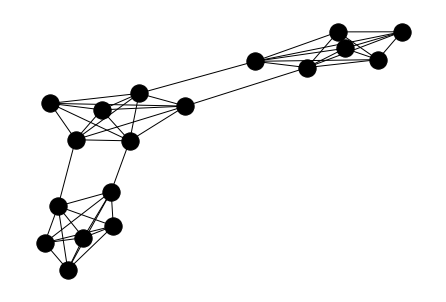

Community connection edges cost:  303.96031034091726 [(2, 6), (0, 9), (7, 13), (11, 17)]
Connector node pairs:  {0: [2, 0], 1: [6, 9, 7, 11], 2: [13, 17]}
Forbidden node connections: 
 {0: [[2, 0]], 1: [[6, 9], [7, 11]], 2: [[13, 17]]}
############################################################
######################## Subgraph: 0 #######################
0 2
Path nodes: 
 {0: [0, 4, 3, 1, 5, 2]}
Path edges: 
 {0: [(0, 4), (4, 3), (3, 1), (1, 5), (5, 2)]}
sub nodes: 
 [0, 4, 3, 1, 5, 2]
sub sorted nodes: 
 [0, 1, 2, 3, 4, 5]
sub edges: 
 [(0, 4), (4, 3), (3, 1), (1, 5), (5, 2)]
Initial solution: 
 15 [0 0 0 1 0 0 1 0 1 0 0 1 1 0 0]
is connected:  True
Is graph connected:  True
Edges for reward list:  [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
Sub reward list: 
 15 [97.26780996631399, 14.274318651259435, 70.45870237305161, 85.29159222760013, 8.56357979506891, 25.118368365444084, 69.48490597868278, 14.149891464

In [4]:
num_workers = 2  # Adjust based on your CPU
seeds = [42, 43]  # One per run
# available_actions, initial_states, distance_matrix, objective_table, reward_list\
#                         = create_single_TSP_initial_solution(node_num, weight_min, weight_max)

available_actions, initial_states, distance_matrix, objective_table, reward_list, start_nodes_dict, end_nodes_dict, connecting_edges \
                    = create_power_grid_line_initial_solution(community_num, nodes_per_comm, weight_min, weight_max)

H_paths = 1

In [5]:
task_args = [
    {"job": "tsp_sub1", "params": {
        "seed": 42, "available_actions": available_actions[0], "initial_state": initial_states[0],
        "distance_matrix": distance_matrix, "objective_table": objective_table, 
        "reward_list": reward_list, "episode_num": episode_num, "max_path_length": max_path_length,
        "path_num": path_num, "node_num": nodes_per_comm, "discount_factor": discount_factor,
        "epsilon": epsilon, "lr": lr, "save_plots": save_plots, "save_data": save_data, "n_step_lookup": n_step_lookup,
        "H_paths": H_paths, "job_num": 1
    }},
    {"job": "tsp_sub2", "params": {
        "seed": 43, "available_actions": available_actions[1], "initial_state": initial_states[1],
        "distance_matrix": distance_matrix, "objective_table": objective_table, 
        "reward_list": reward_list, "episode_num": episode_num, "max_path_length": max_path_length,
        "path_num": path_num, "node_num": nodes_per_comm, "discount_factor": discount_factor,
        "epsilon": epsilon, "lr": lr, "save_plots": save_plots, "save_data": save_data, "n_step_lookup": n_step_lookup,
        "H_paths": H_paths, "job_num": 2
    }},
]

In [6]:
# task_args = [(s, available_actions[0], initial_states, distance_matrix, objective_table, reward_list,\
#               episode_num, max_path_length, path_num, nodes_per_comm,\
#               discount_factor, epsilon, lr, save_plots, n_step_lookup) for s in seeds]

with ProcessPoolExecutor(max_workers=num_workers) as executor:
    # Submit all jobs
    futures = [executor.submit(run_Q_wrapper, args) for args in task_args]

    # Progress bar for completed jobs
    for future in tqdm(as_completed(futures), total=len(futures), desc="Q-learning runs"):
        results.append(future.result())

Q-learning runs:   0%|                                                                           | 0/2 [00:06<?, ?it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\gvozd\anaconda3\lib\concurrent\futures\process.py", line 239, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "C:\Users\gvozd\Desktop\University\Research\Code\Combinatorial RL\TSP RL\Tabular Q-learning PhD Thesis\TI Q-learning\run_jobs.py", line 21, in run_Q_wrapper
    job_func(**task_config["params"])
  File "C:\Users\gvozd\Desktop\University\Research\Code\Combinatorial RL\TSP RL\Tabular Q-learning PhD Thesis\TI Q-learning\run_q_learning.py", line 88, in run_q_learning_instance
    Q, agent_paths, ave_episode_reward = EdgeSwap_Q_learning(epsilon,
  File "C:\Users\gvozd\Desktop\University\Research\Code\Combinatorial RL\TSP RL\Tabular Q-learning PhD Thesis\TI Q-learning\Q_learning.py", line 186, in EdgeSwap_Q_learning
    next_state, reward, done, info = env.step(action)
  File "C:\Users\gvozd\Desktop\University\Research\Code\Combinatorial RL\TSP RL\

TypeError: object of type 'NoneType' has no len()

In [ ]:
with open('Models/best_states_Job_'+str(1)+'_4000_PL_5_Date_2025-05-15_.pkl', 'rb') as f:
    best_states1 = pickle.load(f)

with open('Models/best_states_Job_'+str(2)+'_4000_PL_5_Date_2025-05-15_.pkl', 'rb') as f:
    best_states2 = pickle.load(f)


    
g1 = create_state_graph(nodes_per_comm, best_states1[0][0].tolist())
g2 = create_state_graph(nodes_per_comm, best_states2[0][0].tolist())
nx.draw(g1)
nx.draw(g2)


In [ ]:
RL_optimum_states_g = {0:g1, 1:g2}

In [ ]:
opt_cycle_edges = []
opt_cycle_g = nx.Graph()

for P in range(2): #patches

    print(f'patch: {P}')

    min_node = nodes_per_comm * P

    start_nodes = start_nodes_dict[P]
    end_nodes = end_nodes_dict[P]

    print("Start nodes: ", start_nodes)
    print("End nodes: ", end_nodes)

    #New stuff:
    e_test = list(RL_optimum_states_g[P].edges())
    e_test = [(e[0]+min_node,e[1]+min_node) for e in e_test]
    print("edges: \n", e_test)
    state_g_reconn = nx.Graph()
    state_g_reconn.add_edges_from(e_test)

    state_vec_reconn = create_state_vector(state_g_reconn)

    opt_cycle_edges.extend(e_test)

    nx.draw(RL_optimum_states_g[P], with_labels = True)
    plt.show()
    nx.draw(state_g_reconn, with_labels = True)
    plt.show()



print("Patch connections: \n",connecting_edges)
opt_cycle_edges.extend(connecting_edges)
opt_cycle_g.add_edges_from(opt_cycle_edges)
nx.draw(opt_cycle_g, with_labels = True)
plt.show()

total_reward = 0
ordered_edges = [tuple(sorted(edge)) for edge in opt_cycle_edges]
for e in ordered_edges:
    total_reward += objective_table[e]
print("Reward: ", total_reward)


In [ ]:
from exact_solution import TSP_integer_program

tour_edges = TSP_integer_program(distance_matrix) # solve TSP-MZT integer program.
print("Tour edges: \n", tour_edges)

tour_edges = [(min(e),max(e)) for e in tour_edges]
or_reward = 0
for e in tour_edges:
    or_reward += objective_table[e]
print("Reward: ", or_reward)